In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 1
extraNin: int = 0
Ninter: int = 0
Nout: int = 2
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
R_vec_i = np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 2600  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False

stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 24

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [5]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [0.5 0.5]
input M mismatches output and input
no extra input nodes, no noise added
no inter nodes, no noise added
no extra output nodes, no noise added


In [6]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [7]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [1 2]
extraOutput_nodes_arr  []
ground_nodes_arr  [3]


In [8]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [9]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [10]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

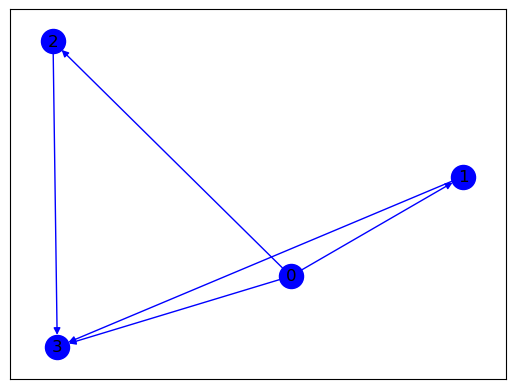

NET is ready


In [11]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [12]:
Strctr.EIEJ_plots

[(0, 1), (0, 2), (0, 3), (1, 3), (2, 3)]

## Train

In [13]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")  
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        # print('p', State.p)
        # print('u', State.u)
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
i 1
k 1
time= 1
solving dual problem
updating Rs
i 2
k 2
i 3
k 3
time= 2
solving dual problem
updating Rs
i 4
k 4
i 5
k 5
time= 3
solving dual problem
updating Rs
i 6
k 6
i 7
k 7
time= 4
solving dual problem
updating Rs
i 8
k 8
i 9
k 9
time= 5
solving dual problem
updating Rs
i 10
k 10
i 11
k 11
time= 6
solving dual problem
updating Rs
i 12
k 12
i 13
k 13
time= 7
solving dual problem
updating Rs
i 14
k 14
i 15
k 15
time= 8
solving dual problem
updating Rs
i 16
k 16
i 17
k 17
time= 9
solving dual problem
updating Rs
i 18
k 18
i 19
k 19
time= 10
solving dual problem
updating Rs
i 20
k 20
i 21
k 21
time= 11
solving dual problem
updating Rs
i 22
k 22
i 23
k 23
time= 12
solving dual problem
updating Rs
i 24
k 24
i 25
k 25
time= 13
solving dual problem
updating Rs
i 26
k 26
i 27
k 27
time= 14
solving dual problem
updating Rs
i 28
k 28
i 29
k 29
time= 15
solving dual problem
updating Rs
i 30
k 30
i 31
k 31
time= 16
solving dual problem
updating Rs
i 32
k 32
i 33
k 33
time= 17
solving 

updating Rs
i 334
k 334
i 335
k 335
time= 168
solving dual problem
updating Rs
i 336
k 336
i 337
k 337
time= 169
solving dual problem
updating Rs
i 338
k 338
i 339
k 339
time= 170
solving dual problem
updating Rs
i 340
k 340
i 341
k 341
time= 171
solving dual problem
updating Rs
i 342
k 342
i 343
k 343
time= 172
solving dual problem
updating Rs
i 344
k 344
i 345
k 345
time= 173
solving dual problem
updating Rs
i 346
k 346
i 347
k 347
time= 174
solving dual problem
updating Rs
i 348
k 348
i 349
k 349
time= 175
solving dual problem
updating Rs
i 350
k 350
i 351
k 351
time= 176
solving dual problem
updating Rs
i 352
k 352
i 353
k 353
time= 177
solving dual problem
updating Rs
i 354
k 354
i 355
k 355
time= 178
solving dual problem
updating Rs
i 356
k 356
i 357
k 357
time= 179
solving dual problem
updating Rs
i 358
k 358
i 359
k 359
time= 180
solving dual problem
updating Rs
i 360
k 360
i 361
k 361
time= 181
solving dual problem
updating Rs
i 362
k 362
i 363
k 363
time= 182
solving dual pro

i 857
k 857
time= 429
solving dual problem
updating Rs
i 858
k 858
i 859
k 859
time= 430
solving dual problem
updating Rs
i 860
k 860
i 861
k 861
time= 431
solving dual problem
updating Rs
i 862
k 862
i 863
k 863
time= 432
solving dual problem
updating Rs
i 864
k 864
i 865
k 865
time= 433
solving dual problem
updating Rs
i 866
k 866
i 867
k 867
time= 434
solving dual problem
updating Rs
i 868
k 868
i 869
k 869
time= 435
solving dual problem
updating Rs
i 870
k 870
i 871
k 871
time= 436
solving dual problem
updating Rs
i 872
k 872
i 873
k 873
time= 437
solving dual problem
updating Rs
i 874
k 874
i 875
k 875
time= 438
solving dual problem
updating Rs
i 876
k 876
i 877
k 877
time= 439
solving dual problem
updating Rs
i 878
k 878
i 879
k 879
time= 440
solving dual problem
updating Rs
i 880
k 880
i 881
k 881
time= 441
solving dual problem
updating Rs
i 882
k 882
i 883
k 883
time= 442
solving dual problem
updating Rs
i 884
k 884
i 885
k 885
time= 443
solving dual problem
updating Rs
i 886
k

updating Rs
i 1436
k 1436
i 1437
k 1437
time= 719
solving dual problem
updating Rs
i 1438
k 1438
i 1439
k 1439
time= 720
solving dual problem
updating Rs
i 1440
k 1440
i 1441
k 1441
time= 721
solving dual problem
updating Rs
i 1442
k 1442
i 1443
k 1443
time= 722
solving dual problem
updating Rs
i 1444
k 1444
i 1445
k 1445
time= 723
solving dual problem
updating Rs
i 1446
k 1446
i 1447
k 1447
time= 724
solving dual problem
updating Rs
i 1448
k 1448
i 1449
k 1449
time= 725
solving dual problem
updating Rs
i 1450
k 1450
i 1451
k 1451
time= 726
solving dual problem
updating Rs
i 1452
k 1452
i 1453
k 1453
time= 727
solving dual problem
updating Rs
i 1454
k 1454
i 1455
k 1455
time= 728
solving dual problem
updating Rs
i 1456
k 1456
i 1457
k 1457
time= 729
solving dual problem
updating Rs
i 1458
k 1458
i 1459
k 1459
time= 730
solving dual problem
updating Rs
i 1460
k 1460
i 1461
k 1461
time= 731
solving dual problem
updating Rs
i 1462
k 1462
i 1463
k 1463
time= 732
solving dual problem
updati

time= 985
solving dual problem
updating Rs
i 1970
k 1970
i 1971
k 1971
time= 986
solving dual problem
updating Rs
i 1972
k 1972
i 1973
k 1973
time= 987
solving dual problem
updating Rs
i 1974
k 1974
i 1975
k 1975
time= 988
solving dual problem
updating Rs
i 1976
k 1976
i 1977
k 1977
time= 989
solving dual problem
updating Rs
i 1978
k 1978
i 1979
k 1979
time= 990
solving dual problem
updating Rs
i 1980
k 1980
i 1981
k 1981
time= 991
solving dual problem
updating Rs
i 1982
k 1982
i 1983
k 1983
time= 992
solving dual problem
updating Rs
i 1984
k 1984
i 1985
k 1985
time= 993
solving dual problem
updating Rs
i 1986
k 1986
i 1987
k 1987
time= 994
solving dual problem
updating Rs
i 1988
k 1988
i 1989
k 1989
time= 995
solving dual problem
updating Rs
i 1990
k 1990
i 1991
k 1991
time= 996
solving dual problem
updating Rs
i 1992
k 1992
i 1993
k 1993
time= 997
solving dual problem
updating Rs
i 1994
k 1994
i 1995
k 1995
time= 998
solving dual problem
updating Rs
i 1996
k 1996
i 1997
k 1997
time= 

updating Rs
i 2536
k 2536
i 2537
k 2537
time= 1269
solving dual problem
updating Rs
i 2538
k 2538
i 2539
k 2539
time= 1270
solving dual problem
updating Rs
i 2540
k 2540
i 2541
k 2541
time= 1271
solving dual problem
updating Rs
i 2542
k 2542
i 2543
k 2543
time= 1272
solving dual problem
updating Rs
i 2544
k 2544
i 2545
k 2545
time= 1273
solving dual problem
updating Rs
i 2546
k 2546
i 2547
k 2547
time= 1274
solving dual problem
updating Rs
i 2548
k 2548
i 2549
k 2549
time= 1275
solving dual problem
updating Rs
i 2550
k 2550
i 2551
k 2551
time= 1276
solving dual problem
updating Rs
i 2552
k 2552
i 2553
k 2553
time= 1277
solving dual problem
updating Rs
i 2554
k 2554
i 2555
k 2555
time= 1278
solving dual problem
updating Rs
i 2556
k 2556
i 2557
k 2557
time= 1279
solving dual problem
updating Rs
i 2558
k 2558
i 2559
k 2559
time= 1280
solving dual problem
updating Rs
i 2560
k 2560
i 2561
k 2561
time= 1281
solving dual problem
updating Rs
i 2562
k 2562
i 2563
k 2563
time= 1282
solving dual 

## Plots

### importants + network

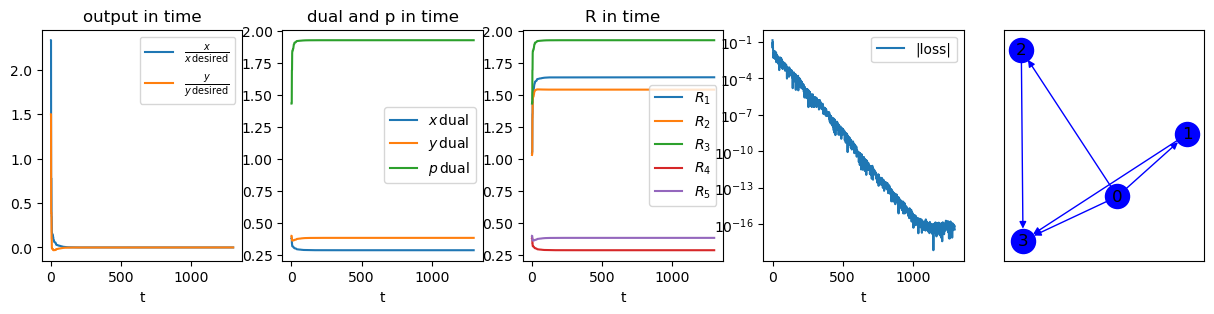

In [14]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

### accuracy

In [15]:
import importlib 
# Re-import the module import your_module 
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

In [16]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [17]:
# State.accuracy_in_t

In [18]:
State.output_in_t

[array([0.37454012, 0.37454012]),
 array([0.95071431, 0.95071431]),
 array([0.39249957, 0.40947429]),
 array([0.32100429, 0.334887  ]),
 array([0.08300494, 0.08667756]),
 array([0.08299211, 0.08666416]),
 array([0.03090161, 0.03226887]),
 array([0.4608225 , 0.48121196]),
 array([0.24331662, 0.26393889]),
 array([0.28661042, 0.31090205]),
 array([0.0083181 , 0.00902711]),
 array([0.39193628, 0.42534379]),
 array([0.29533101, 0.33234233]),
 array([0.07533291, 0.08477374]),
 array([0.06304273, 0.07178467]),
 array([0.0635904 , 0.07240828]),
 array([0.10548749, 0.12011512]),
 array([0.18194463, 0.20717433]),
 array([0.14941648, 0.17036901]),
 array([0.10074068, 0.11486745]),
 array([0.21145353, 0.24123879]),
 array([0.04820843, 0.05499905]),
 array([0.09992557, 0.11471231]),
 array([0.12531093, 0.14385412]),
 array([0.15595927, 0.179064  ]),
 array([0.2685015 , 0.30827889]),
 array([0.06797649, 0.07827237]),
 array([0.1750648 , 0.20158055]),
 array([0.20089901, 0.23192557]),
 array([0.0157

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [19]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

u [0.51946063 0.51946063 0.51946063 0.51946063 0.51946063]
Rs [1.63631265 1.54005896 1.9250737  0.28876106 0.38501474]
Power dissipation 1.5583818929835709


## Save sizes to file

In [20]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

### R change scheme under 2 tasks

In [21]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

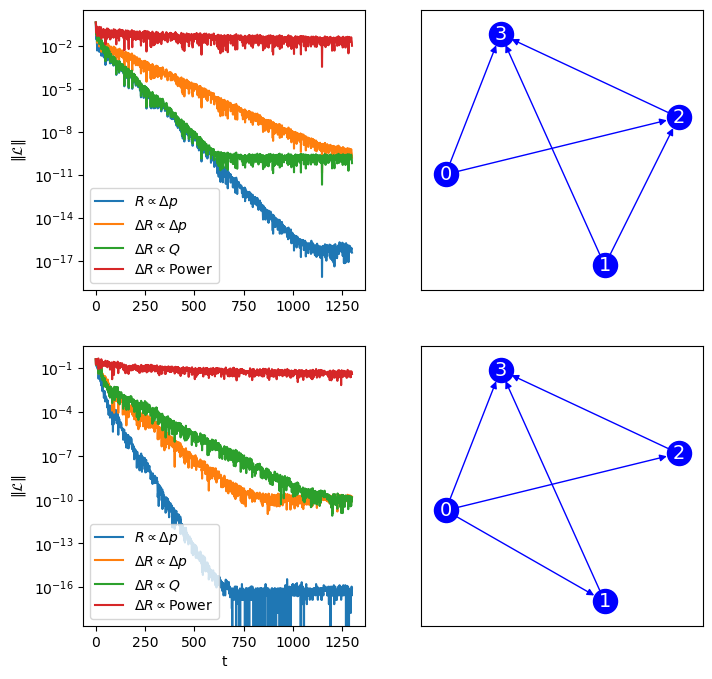

In [22]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(t, Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [23]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

In [24]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

plot_functions.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

AttributeError: module 'plot_functions' has no attribute 'plot_performance_2'

### different R relations

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [ ]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [ ]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [ ]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

In [ ]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_final.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/accuracy.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/dataset_len.npy')

In [ ]:
plot_functions.plot_accuracy(t_final, t_for_accuracy, accuracy_in_t, dataset_len)

## Statistics

### Error

In [ ]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)